In [1]:
import json
import os

import pprint as pp

import numpy as np
import pandas as pd

import openmdao.api as om

import matplotlib.pyplot as plt
import tools_cvf

plt.style.use(tools_cvf.get_stylesheets(dark=True))

In [2]:

# This function loads the openmdao sql file and does most of the work here
def load_OMsql(log):
    print('loading {}'.format(log))
    cr = om.CaseReader(log)
    rec_data = {}
    # driver_cases = cr.list_cases('driver')
    cases = cr.get_cases('driver')
    for case in cases:
        for key in case.outputs.keys():
            if key not in rec_data:
                rec_data[key] = []
            rec_data[key].append(case[key])
    return rec_data

%cd ~/codes/WEIS/examples/17_IEA22_Optimization

/home/cfrontin/codes/WEIS/examples/17_IEA22_Optimization


In [3]:
dir_template = "32_DesignRound1_%s"

dir_COBYLA = dir_template % "COBYLA"
dir_SLSQP = dir_template % "SLSQP"

fn_log_COBYLA = os.path.join(dir_COBYLA, "log_opt.sql")
fn_log_SLSQP = os.path.join(dir_SLSQP, "log_opt.sql")

In [4]:
fn_vars_COBYLA = os.path.join(dir_COBYLA, "problem_vars.json")
fn_vars_SLSQP = os.path.join(dir_SLSQP, "problem_vars.json")

with open(fn_vars_COBYLA, "r") as fjson_COBYLA:
  vars_COBYLA = {k: dict(v) for k, v in json.load(fjson_COBYLA).items()}
with open(fn_vars_SLSQP, "r") as fjson_SLSQP:
  vars_SLSQP = {k: dict(v) for k, v in json.load(fjson_SLSQP).items()}

for k0 in set(vars_COBYLA.keys()).union(vars_SLSQP):
  assert k0 in vars_COBYLA
  assert k0 in vars_SLSQP
  for k1 in set(vars_COBYLA[k0].keys()).union(vars_SLSQP[k0].keys()):
    assert k1 in vars_COBYLA[k0]
    assert k1 in vars_SLSQP[k0]
    for k2 in set(vars_COBYLA[k0][k1].keys()).union(vars_SLSQP[k0][k1].keys()):
      assert k2 in vars_COBYLA[k0][k1]
      assert k2 in vars_SLSQP[k0][k1]
      if k2 == "val": continue
      if isinstance(vars_COBYLA[k0][k1][k2], str):
        assert vars_COBYLA[k0][k1][k2] == vars_SLSQP[k0][k1][k2]
      elif vars_COBYLA[k0][k1][k2] is not None:
        assert np.all(np.isclose(vars_COBYLA[k0][k1][k2], vars_SLSQP[k0][k1][k2]))
      else:
        assert (vars_COBYLA[k0][k1][k2] is None) and (vars_SLSQP[k0][k1][k2] is None)

vars_unified = vars_COBYLA.copy()
for k0 in vars_unified.keys():
  for k1 in vars_unified[k0].keys():
    if (vars_unified[k0][k1].get("lower") is not None) and (vars_unified[k0][k1].get("lower") < -1e+28):
      vars_unified[k0][k1]["lower"] = -np.inf
    if (vars_unified[k0][k1].get("upper") is not None) and (vars_unified[k0][k1].get("upper") > 1e+28):
      vars_unified[k0][k1]["upper"] = np.inf

In [5]:
vars_unified.keys()

dict_keys(['design_vars', 'constraints', 'objectives'])

In [6]:
dataOM_COBYLA = load_OMsql(fn_log_COBYLA)
dataOM_SLSQP = load_OMsql(fn_log_SLSQP)
print()
if len(set(dataOM_COBYLA).difference(dataOM_SLSQP)):
  print("the following keys are only in COBYLA:")
for key_m in set(dataOM_COBYLA).difference(dataOM_SLSQP):
  print(f"\t{key_m}")
if len(set(dataOM_SLSQP).difference(dataOM_COBYLA)):
  print("the following keys are only in SLSQP:")
for key_m in set(dataOM_SLSQP).difference(dataOM_COBYLA):
  print(f"\t{key_m}")
keys_all = set(dataOM_COBYLA).intersection(dataOM_SLSQP)
print("the following keys are in both:")
for key_m in keys_all:
  print(f"\t{key_m}")
print()
# dataOM_working = load_OMsql("32_DesignRound1/log_opt.sql")
# keys_all = set(dataOM_working)

keys_obj = [v["name"] for k, v in vars_unified["objectives"].items()]
keys_DV = [v["name"] for k, v in vars_unified["design_vars"].items()]
keys_constr = {v["name"]: [v["lower"], v["upper"]] for k, v in vars_unified["constraints"].items()}

print()
[
  print(
    f"** {key}" if key in keys_obj
      else f"-- {key}" if key in keys_DV
      else f"<> {key}" if key in keys_constr
      else f"?? {key}"
  ) for key in keys_all
]
print()

loading 32_DesignRound1_COBYLA/log_opt.sql
loading 32_DesignRound1_SLSQP/log_opt.sql

the following keys are in both:
	floatingse.constr_fairlead_wave
	floatingse.constr_draft_heel_margin
	floatingse.metacentric_height
	raft.pitch_period
	floating.memgrp1.outer_diameter_in
	floatingse.constr_fixed_margin
	floatingse.constr_freeboard_heel_margin
	floatingse.constr_variable_margin
	raft.heave_period
	floating.jointdv_1
	floating.jointdv_0
	floatingse.system_structural_mass
	raft.Max_PtfmPitch


<> floatingse.constr_fairlead_wave
<> floatingse.constr_draft_heel_margin
<> floatingse.metacentric_height
<> raft.pitch_period
-- floating.memgrp1.outer_diameter_in
<> floatingse.constr_fixed_margin
<> floatingse.constr_freeboard_heel_margin
<> floatingse.constr_variable_margin
<> raft.heave_period
-- floating.jointdv_1
-- floating.jointdv_0
** floatingse.system_structural_mass
<> raft.Max_PtfmPitch



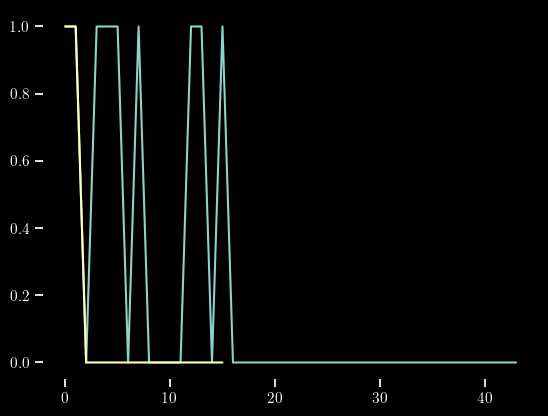

In [62]:
def get_feasible_iterations(dataOM, vars_dict):
    feasibility_constraintwise = dict()
    total_feasibility = np.ones_like(dataOM[next(iter(vars_COBYLA["objectives"].values()))["name"]], dtype=bool)
    for k, v in vars_dict["constraints"].items():
        feasibility = np.ones_like(dataOM[next(iter(vars_COBYLA["objectives"].values()))["name"]], dtype=bool)
        values = np.array(dataOM[v["name"]]).reshape(feasibility.shape[0], -1)
        # print("feasibility shape:", feasibility.shape)
        # print("values shape:", values.shape)
        # print("all shape:", np.all(values <= v["upper"], axis=1).reshape(-1,1).shape)
        # print("and shape:", np.logical_and(feasibility, np.all(values <= v["upper"], axis=1).reshape(-1,1)).shape)
        if v.get("upper") is not None:
            feasibility = np.logical_and(feasibility, np.all(values <= v["upper"], axis=1).reshape(-1,1))
        if v.get("lower") is not None:
            feasibility = np.logical_and(feasibility, np.all(values >= v["lower"], axis=1).reshape(-1,1))
        feasibility_constraintwise[k] = feasibility
        total_feasibility = np.logical_and(total_feasibility, feasibility)
    return total_feasibility, feasibility_constraintwise

tfeas, data = get_feasible_iterations(dataOM_COBYLA, vars_COBYLA)
plt.plot(tfeas)
tfeas, data = get_feasible_iterations(dataOM_SLSQP, vars_SLSQP)
plt.plot(tfeas)

In [156]:
def plot_conv(keyset_in):
    if len(keyset_in) == 0: return

    fig, axes = plt.subplots(
        len(keyset_in), 1,
        sharex=True, figsize=(6,0.60*4*len(keyset_in)), squeeze=False,
    dpi=150,
    )

    has_ref_vals = type(keyset_in) == dict

    if has_ref_vals:
        key_val_map = keyset_in
        keyset = keyset_in.keys()
    else:
        keyset = keyset_in

    for imethod, method in enumerate(["COBYLA", "SLSQP"]):
        axes[0, 0].plot(
            [], [],
            "w"+(".-" if method == "COBYLA" else "*-" if method == "SLSQP" else "x-"),
            label=method,
        )
        dataOM = dataOM_COBYLA if method == "COBYLA" else (dataOM_SLSQP if method == "SLSQP" else None)
        vars = vars_COBYLA if method == "COBYLA" else (vars_SLSQP if method == "SLSQP" else None)
        tfeas, _ = get_feasible_iterations(dataOM, vars)
        # print(sum(tfeas), len(tfeas))
        for idx_ax, key in enumerate(keyset):
            pt0 = axes[idx_ax, 0].plot(
                np.squeeze(dataOM[key]), "-", label="".join(["_", method, "_"]),
            )
            # print(np.array(dataOM[key]).shape, (tfeas*np.ones((1, np.array(dataOM[key]).shape[1]))).shape)
            axes[idx_ax, 0].plot(
                np.ma.array(dataOM[key], mask=~(tfeas*np.ones((1, np.array(dataOM[key]).shape[1]), dtype=bool))),
                "o" if method == "COBYLA" else "p" if method == "SLSQP" else "x",
                label="".join(["_", method, "_"]),
                color=pt0[-1].get_color(),
                fillstyle="full"
            )
            axes[idx_ax, 0].plot(
                np.ma.array(dataOM[key], mask=(tfeas*np.ones((1, np.array(dataOM[key]).shape[1]), dtype=bool))),
                "o" if method == "COBYLA" else "p" if method == "SLSQP" else "x",
                label="".join(["_", method, "_"]),
                color=pt0[-1].get_color(),
                fillstyle="none"
            )
            if has_ref_vals and (imethod == 0):
                cval = key_val_map[key]
                if cval[0] is not None: axes[idx_ax, 0].plot([0, len(dataOM[key])], [cval[0], cval[0]], "b:", label="_lower bound_")
                if cval[1] is not None: axes[idx_ax, 0].plot([0, len(dataOM[key])], [cval[1], cval[1]], "r:", label="_upper bound_")
            axes[idx_ax, 0].set_title(key)

    if has_ref_vals:
        axes[0, 0].plot([], [], "b:", label="lower bound")
        axes[0, 0].plot([], [], "r:", label="upper bound")
    axes[0, 0].legend()
    fig.tight_layout()

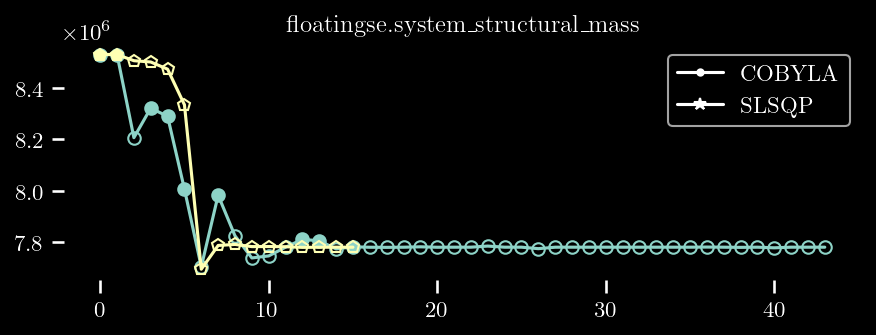

In [157]:
plot_conv(keys_obj)

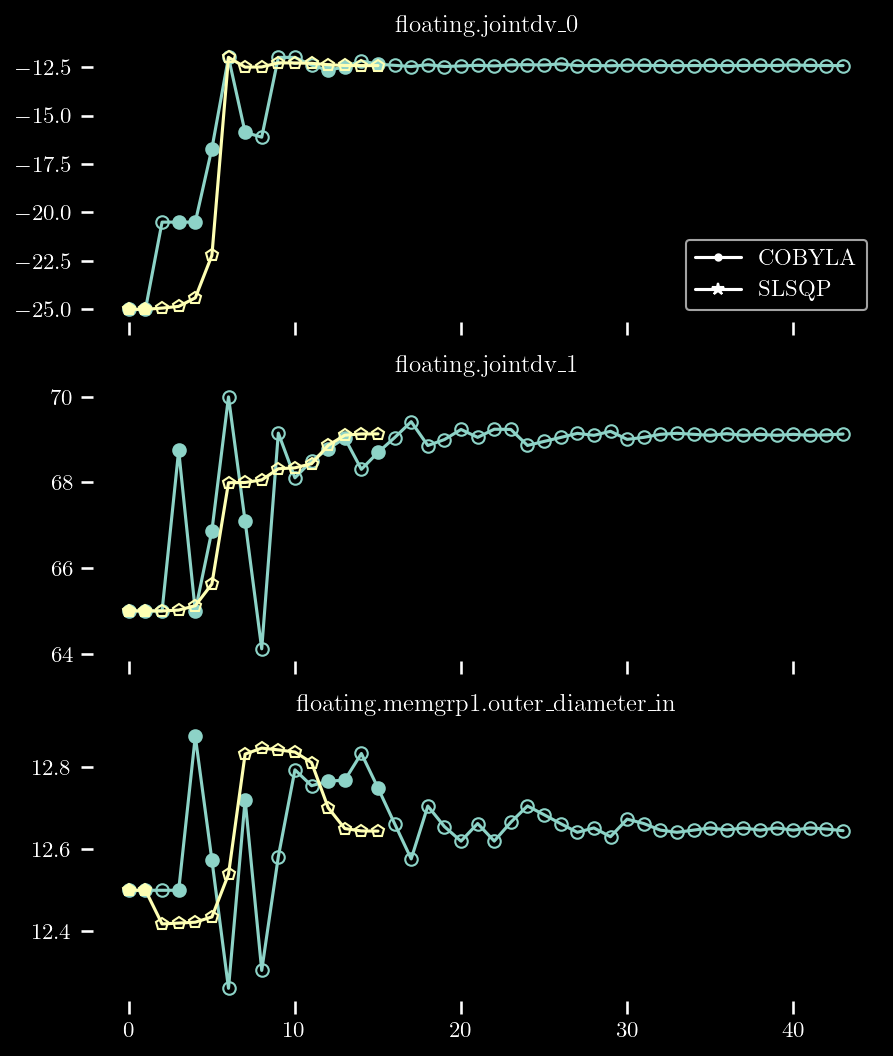

In [158]:
plot_conv(keys_DV)

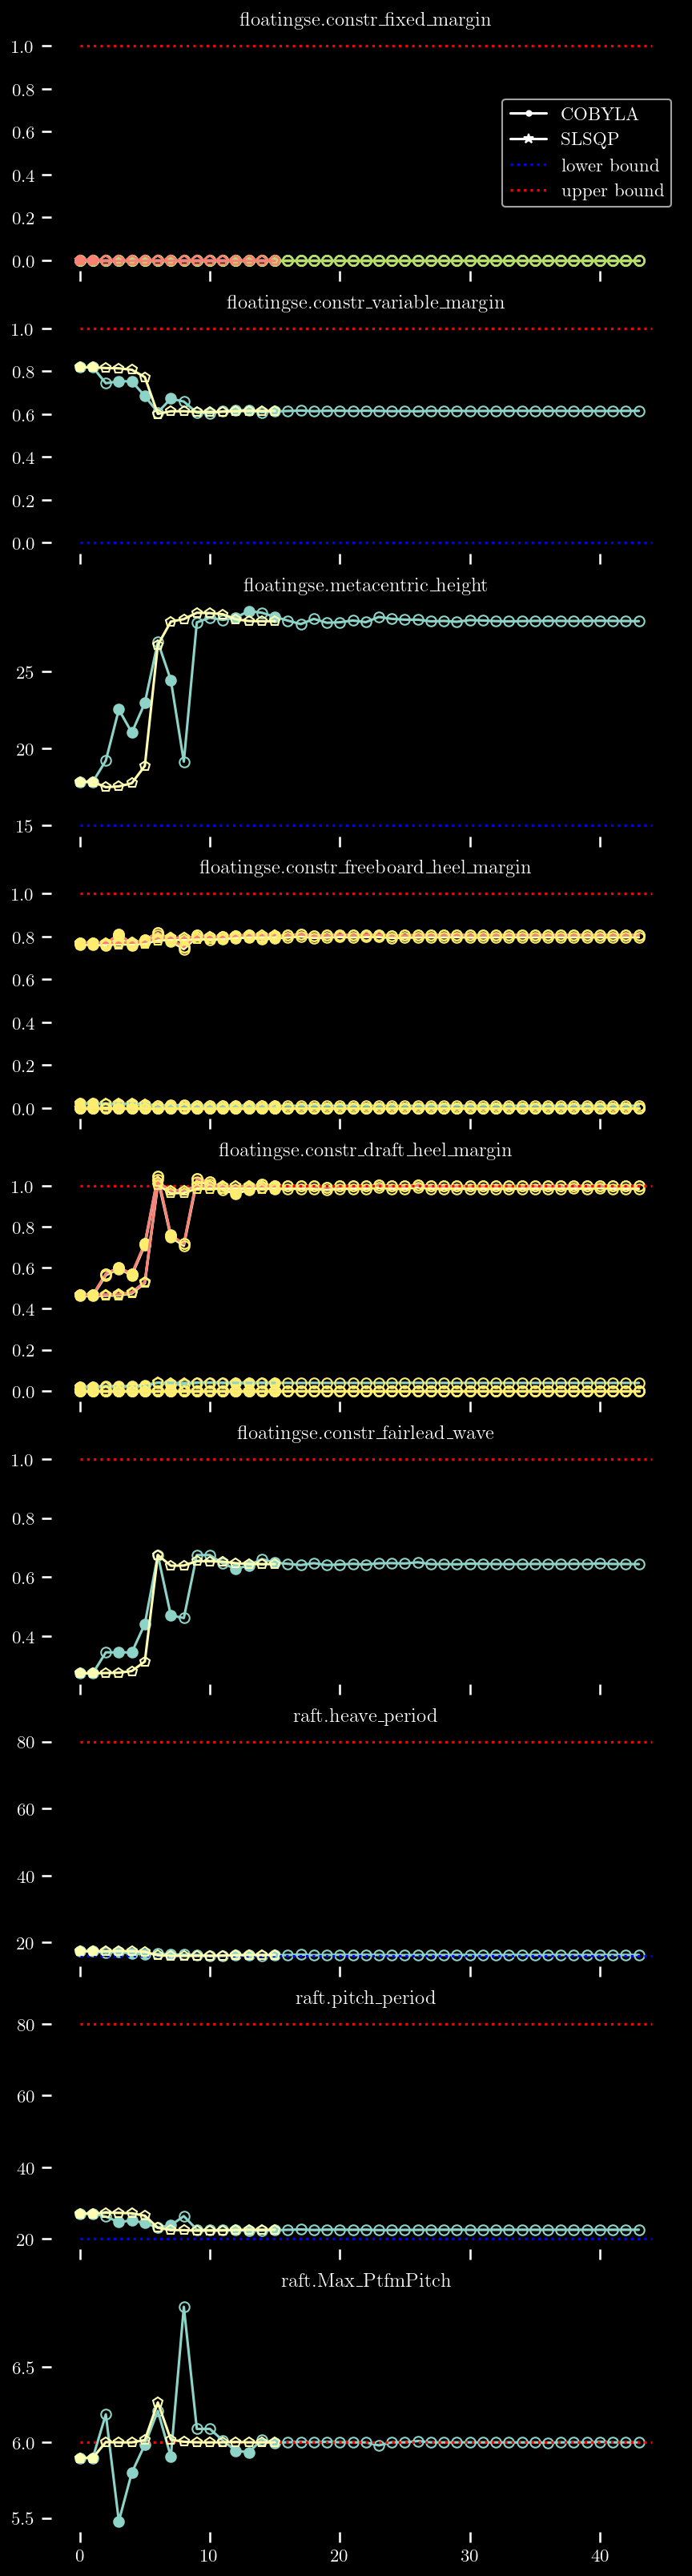

In [159]:
plot_conv(keys_constr)